In [1]:
# CELL 0 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")


/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_12668/3577118552.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(start="2021-01-01", periods=48, freq="M")


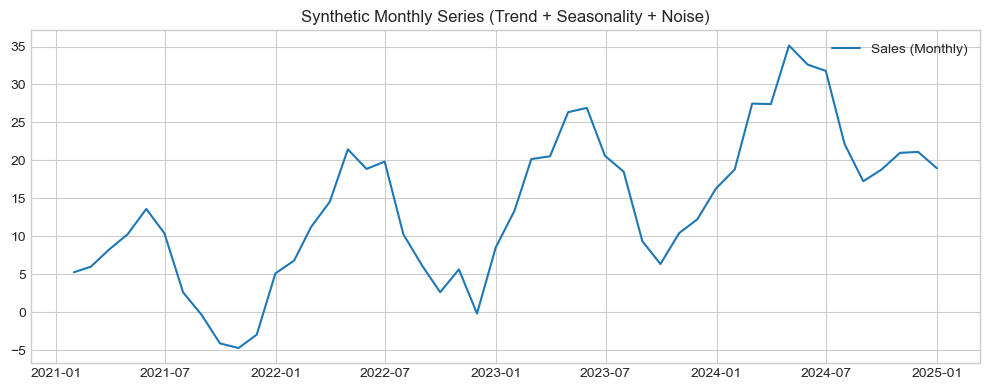

In [2]:
# CELL 1 — Create a time series `ts` (monthly, 4 years, with trend + yearly seasonality + noise)

# Synthetic but realistic monthly series (48 months)
idx = pd.date_range(start="2021-01-01", periods=48, freq="M")

# Components: linear trend + yearly seasonality + random noise
t = np.arange(48)
trend = 0.6 * t
seasonal = 10 * np.sin(2 * np.pi * t / 12)  # yearly (12-month) seasonality
noise = np.random.normal(scale=2.0, size=48)

ts = pd.Series(trend + seasonal + noise, index=idx, name="Sales")

# Quick peek
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ts, label="Sales (Monthly)")
ax.set_title("Synthetic Monthly Series (Trend + Seasonality + Noise)")
ax.legend()
plt.tight_layout()
plt.show()


In [7]:
ts.iloc[:-12]

2021-01-31     5.251769
2021-02-28     5.977873
2021-03-31     8.287986
2021-04-30    10.255714
2021-05-31    13.594446
2021-06-30    10.383481
2021-07-31     2.599855
2021-08-31    -0.397770
2021-09-30    -4.125963
2021-10-31    -4.732701
2021-11-30    -2.970205
2021-12-31     5.104939
2022-01-31     6.790496
2022-02-28    11.212775
2022-03-31    14.534901
2022-04-30    21.448838
2022-05-31    18.862719
2022-06-30    19.835418
2022-07-31    10.246935
2022-08-31     6.137740
2022-09-30     2.618286
2022-10-31     5.633782
2022-11-30    -0.192743
2022-12-31     8.517344
2023-01-31    13.337231
2023-02-28    20.166617
2023-03-31    20.532591
2023-04-30    26.344193
2023-05-31    26.908993
2023-06-30    20.599205
2023-07-31    18.506006
2023-08-31     9.344443
2023-09-30     6.337384
2023-10-31    10.415235
2023-11-30    12.221819
2023-12-31    16.286816
Freq: ME, Name: Sales, dtype: float64

In [8]:
# CELL 2 — Chronological split, fit ARIMA(1,1,1), get residuals

# Last 12 months as a simple holdout
train = ts.iloc[:-12]
test  = ts.iloc[-12:]

# Fit ARIMA on TRAIN only
model = ARIMA(train, order=(1,1,1))
fit = model.fit()

# Residuals from the fitted model (in-sample)
resid = fit.resid

print(fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -102.482
Date:                Mon, 01 Dec 2025   AIC                            210.965
Time:                        10:27:29   BIC                            215.631
Sample:                    01-31-2021   HQIC                           212.575
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4884      0.511      0.956      0.339      -0.513       1.489
ma.L1         -0.2094      0.584     -0.358      0.720      -1.354       0.936
sigma2        20.3963      5.471      3.728      0.0

In [13]:
resid

2021-01-31     5.251769
2021-02-28     0.726069
2021-03-31     2.093393
2021-04-30     1.275969
2021-05-31     2.644759
2021-06-30    -4.287915
2021-07-31    -7.113190
2021-08-31    -0.685335
2021-09-30    -2.407528
2021-10-31     0.710120
2021-11-30     2.207565
2021-12-31     7.676553
2022-01-31    -0.651148
2022-02-28     3.462612
2022-03-31     1.887195
2022-04-30     5.686457
2022-05-31    -4.772389
2022-06-30     1.236474
2022-07-31    -9.804660
2022-08-31    -1.478960
2022-09-30    -1.822042
2022-10-31     4.353005
2022-11-30    -6.387855
2022-12-31    10.218330
2023-01-31     2.705333
2023-02-28     5.041658
2023-03-31    -1.914029
2023-04-30     5.232016
2023-05-31    -1.178205
2023-06-30    -6.832397
2023-07-31    -0.442001
2023-08-31    -8.231706
2023-09-30    -0.255952
2023-10-31     5.493043
2023-11-30     0.965091
2023-12-31     3.384679
Freq: ME, dtype: float64

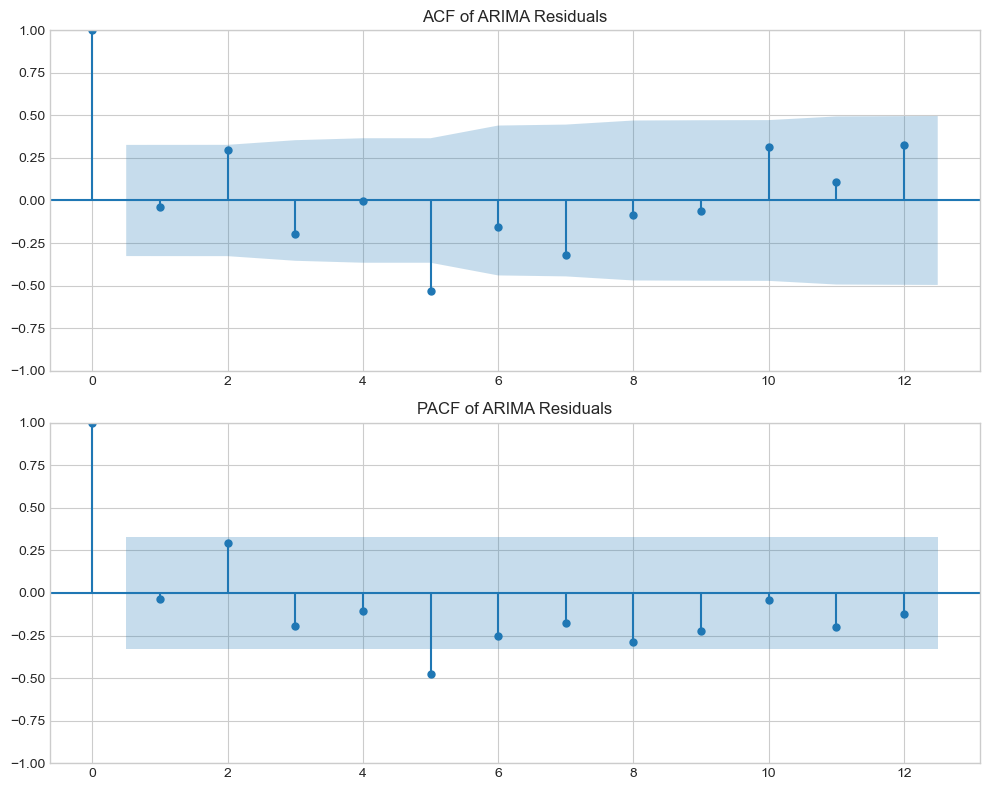

In [9]:
# CELL 3 — Residual ACF & PACF

fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(resid, ax=ax[0], lags=12)
ax[0].set_title("ACF of ARIMA Residuals")

plot_pacf(resid, ax=ax[1], lags=12, method="ywm")
ax[1].set_title("PACF of ARIMA Residuals")

plt.tight_layout()
plt.show()


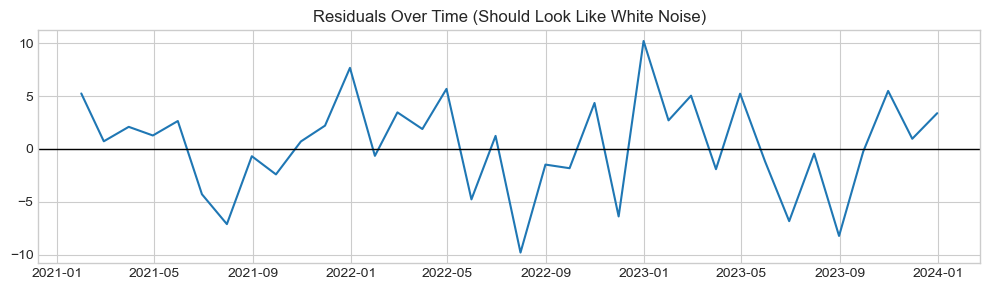

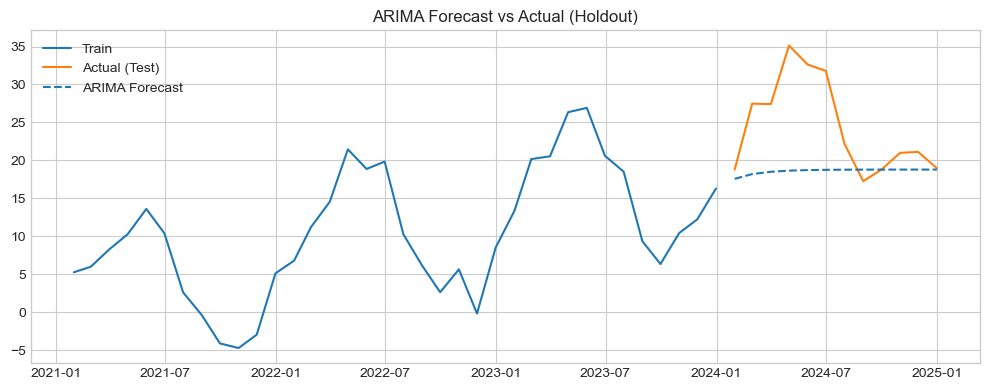

In [10]:
# CELL 4 — (Optional) Visual residual check & simple forecast plot

# Residuals over time (should look like random noise around 0)
plt.figure(figsize=(10,3))
plt.plot(resid)
plt.axhline(0, color="black", lw=1)
plt.title("Residuals Over Time (Should Look Like White Noise)")
plt.tight_layout()
plt.show()

# Forecast next 12 and compare visually
pred = fit.forecast(steps=len(test))
plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Actual (Test)", color="#ff7f0e")
plt.plot(pred,  label="ARIMA Forecast", color="#1f77b4", ls="--")
plt.title("ARIMA Forecast vs Actual (Holdout)")
plt.legend()
plt.tight_layout()
plt.show()


***
## Code Along

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_12668/1530914022.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2021-01-01', periods=48, freq='M')


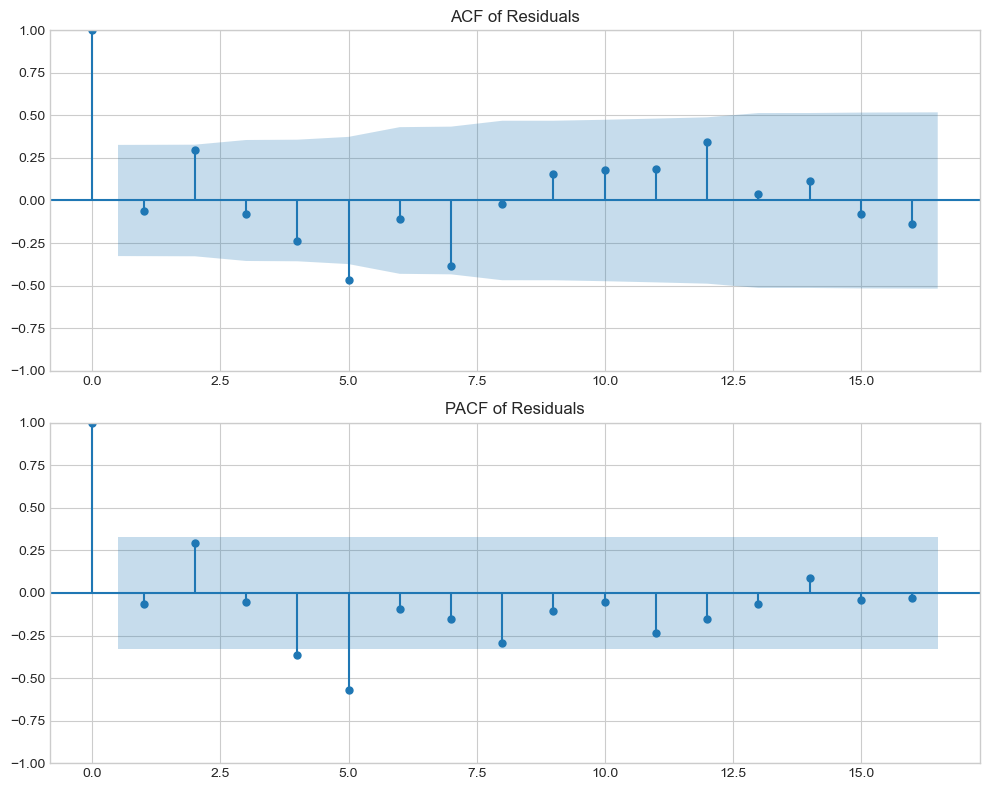

In [11]:
# --- First, we must recreate the model from Reading 20 ---
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

dates = pd.date_range(start='2021-01-01', periods=48, freq='M')
data = np.arange(1, 49) + np.sin(np.arange(1, 49) * (2 * np.pi / 12)) * 10 + np.random.randn(48) * 2
ts = pd.Series(data, index=dates, name='Sales')
train_data = ts.iloc[:-12]
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
# --- End of setup ---


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Get the model's residuals
residuals = model_fit.resid

# Create a figure for the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF of the residuals
plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# Plot the PACF of the residuals
plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

11:25:24 - cmdstanpy - INFO - Chain [1] start processing
11:25:25 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
43 2024-08-31  32.397007   30.799536   34.088555
44 2024-09-30  35.752740   34.116371   37.251215
45 2024-10-31  33.781184   32.187378   35.368160
46 2024-11-30  43.751138   42.105320   45.479941
47 2024-12-31  54.291346   52.661046   55.952468


/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


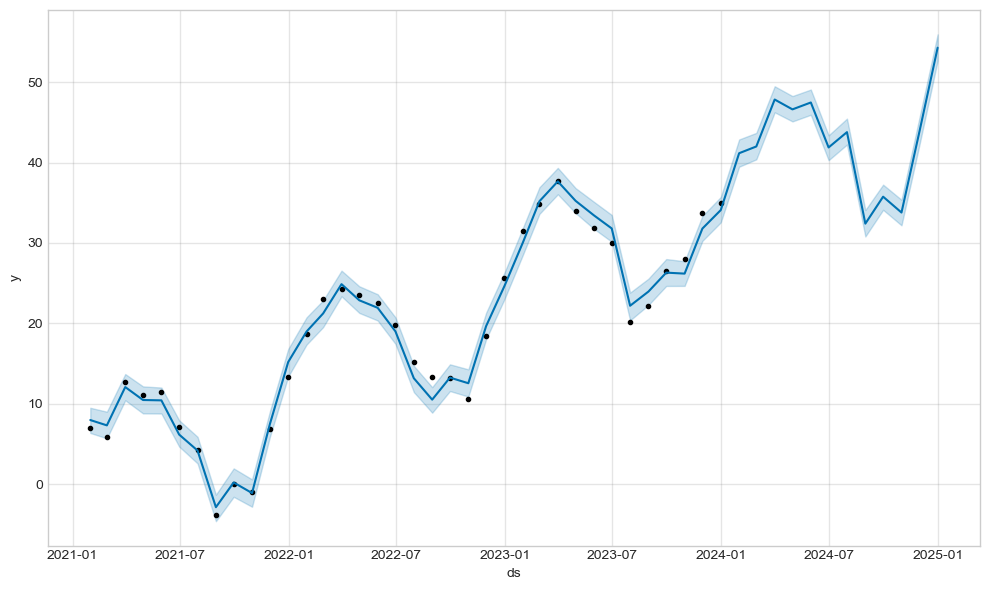

In [12]:
# NOTE: You may need to install this library first!
# pip install prophet
from prophet import Prophet

# --- Prepare data for Prophet ---
# Prophet requires very specific column names:
# 'ds' for the datestamp
# 'y' for the value we want to forecast
df_prophet = ts.reset_index()
df_prophet.columns = ['ds', 'y']
df_train = df_prophet.iloc[:-12]

# --- 1. Initialize and Fit ---
# Prophet finds the best parameters automatically
m = Prophet()
m.fit(df_train)

# --- 2. Create Future Dates ---
# Create a DataFrame for the 12 months we want to predict
future = m.make_future_dataframe(periods=12, freq='M')

# --- 3. Predict ---
forecast = m.predict(future)

# --- 4. Visualize ---
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = m.plot(forecast)
plt.show()